In [1]:
import matplotlib as mpl
mpl.use('Agg')
from LiteNet import *
from Datasets import *
import tensorflow as tf
import numpy as np
import h5py as h5
import matplotlib.pyplot as plt
from time import time
from tqdm import tqdm, trange
from scipy.stats import norm
from nystrom_kexpfam.estimators.KMCLite import KMCLite
from nystrom_kexpfam.data_generators.Ring import Ring
np.set_printoptions(precision=3, linewidth=120)

%matplotlib inline

KERNEL_EXP_FAMILY: INFO: 2018-05-12 17:02:02,100: log.<module>(): Global logger initialised with loglevel 20
/nfs/nhome/live/kevinli/anaconda/lib/python2.7/site-packages/theano/gpuarray/dnn.py:135: UserWarning: Your cuDNN version is more recent than Theano. If you encounter problems, try updating Theano or downgrading cuDNN to version 5.1.
  warnings.warn("Your cuDNN version is more recent than "
ERROR (theano.gpuarray): Could not initialize pygpu, support disabled
Traceback (most recent call last):
  File "/nfs/nhome/live/kevinli/anaconda/lib/python2.7/site-packages/theano/gpuarray/__init__.py", line 164, in <module>
    use(config.device)
  File "/nfs/nhome/live/kevinli/anaconda/lib/python2.7/site-packages/theano/gpuarray/__init__.py", line 151, in use
    init_dev(device)
  File "/nfs/nhome/live/kevinli/anaconda/lib/python2.7/site-packages/theano/gpuarray/__init__.py", line 68, in init_dev
    context.cudnn_handle = dnn._make_handle(context)
  File "/nfs/nhome/live/kevinli/anaconda/

In [2]:
D = 2
p = Ring(D=D, sigma=0.1
         , N_train=10000, N_test=10000)
p = Spiral(D=D, r_scale=1.5, sigma=0.1, starts=[0.1,0.5,1.5,4], length=np.pi)
p = Funnel(sigma=2, D=D, lim=10)


plot_size=12
ngrid = 100

eval_grid = np.linspace(-plot_size/2,plot_size/2,ngrid) 

if D == 2:
    eval_points = np.array([[xv,yv] 
        for xv in eval_grid
                for yv in eval_grid])


def gen_data(n):
        
    d = p.sample(n)
    
    return d

def visualize_kernel(kn, grid_one, N, points = np.array([[0,0.0]]),**kwargs):
    
    '''
    Plot effective kernels 
    '''
    ngrid = len(grid_one)
    npoint = points.shape[0]
    grid_one = grid_one.astype(FDTYPE)
    
    points = tf.constant(points, dtype=FDTYPE)
    
    grid = np.meshgrid(grid_one,grid_one)
    grid = np.stack(grid, 2).reshape(-1,2)

    grid = tf.constant(grid)

    K = kn.evaluate_gram(points, grid)
    K_eval = sess.run(K).reshape(npoint, ngrid,ngrid)
    
    for i in range(npoint):
        
        plt.contour(grid_one, grid_one, K_eval[i], N, 
                    vmin=K_eval[:-1,:-1].min(), vmax=K_eval[:-1,:-1].max(), **kwargs)
            
    plt.gca().set_aspect("equal")
    return K_eval

def true_score(gt, ge):
    return 0.5*np.mean(np.sum((gt - ge)**2,1))

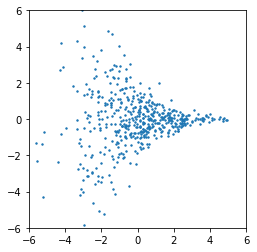

In [3]:
rand_train_data = gen_data(500)
plt.scatter(rand_train_data[:,0],rand_train_data[:,1],2)
plt.xlim([-6,6])
plt.ylim([-6,6])
plt.gca().set_aspect("equal")

### Training parameters
* `net_type`: `"d"` for deep kernel, need to specify `nlayer`
* `step_size`: step size for all algorithms
* `niter`: number of training iterations
* `ndim` : shape of input to the network as a tuple
* `npoint`: number of inducing points
* `ntrain:` number of training data
* `nvalid:`   number of validation data

### model parameters
* `init_std`: std for network weights
* `sigma`   : width of Gaussian kernel
* `lam_*`   : regulariser for RKHS norm, alpha l-2, curvature, network weights (constant)
* `tb_log_dir`: tensorboard log dir directory

In [28]:
np.random.seed(2)


net_type = "d" 
nlayer = 3
step_size = 1e-2
niter = 500

ndim = (10,)
npoint = 500

ntrain = npoint
nvalid = 500


init_std = 5e-1
sigma = 10**(tf.Variable(0, dtype=FDTYPE))
lam_norm = 10**(tf.Variable(0, dtype=FDTYPE))
lam_alpha = 10**(tf.Variable(0, dtype=FDTYPE))

#lam_alpha = tf.identity(lam_norm)
lam_curve = 10**(tf.Variable(0, dtype=FDTYPE))
lam_weights = 10**(tf.constant(-3, dtype=FDTYPE))

tb_log_dir = "tb_logs/ds%s_nt%s_nl%d_ss%d_is%d" % (p.name, 
                                                   net_type, 
                                                   nlayer, 
                                                   np.log10(step_size), 
                                                   np.log(init_std))

In [35]:
train_data = tf.placeholder(FDTYPE, shape=(None, D), name="train_data")
val_data = tf.placeholder(FDTYPE, shape=(None, D), name="valid_data")
test_data = tf.placeholder(FDTYPE, shape=(None, D), name="test_data")
points  = tf.placeholder(FDTYPE, shape=(npoint, D), name="points")

rand_val_data = gen_data(nvalid)
rand_test_data = gen_data(nvalid)
rand_points = gen_data(npoint)

if hasattr(p, "grad_multiple"):
    test_grad_true = p.grad_multiple(rand_test_data)


print '=====building network'
if net_type=="i":
    kernel  = GaussianKernel(sigma)
elif net_type=="d":
    kernel  = GaussianKernel(sigma)
    layer_1 = LinearSoftNetwork((D,), ndim, init_std=init_std)
    layers = [LinearSoftNetwork(ndim, ndim, init_std=init_std) for i in range(nlayer-1)]
    network = DeepNetwork([layer_1, ] + layers)
    kernel = CompositeKernel(kernel, network)
    #kernel = MixtureKernel([kernel, PolynomialKernel(2)], [1.0, -tf.constant(1e-2, dtype=FDTYPE)])
    #kernel = NetworkKernel(network)

kn = LiteModel(kernel, points=points)

loss, score, train_data, val_data, r_norm, l_norm, curve, w_norm = \
    kn.val_score(train_data=train_data, val_data = val_data, 
                 lam_norm=lam_norm, lam_alpha=lam_alpha, lam_curve=lam_curve, lam_weights=lam_weights)

tf.summary.scalar("param_norm", w_norm)


hv, gv, fv = kn.evaluate_hess_grad_fun(test_data)

feed   = {train_data: rand_train_data,
          val_data  : rand_val_data,
          test_data : rand_test_data}
feed[points] = feed[train_data]

tf.summary.scalar("score", score)
tf.summary.scalar("loss", loss)
tf.summary.scalar("lam_norm", lam_norm)
tf.summary.scalar("lam_alpha", lam_alpha)
tf.summary.scalar("lam_curve", lam_curve)
tf.summary.scalar("rkhs_norm", r_norm)
tf.summary.scalar("l2_norm", l_norm)
tf.summary.scalar("curve", curve)

merged = tf.summary.merge_all()

=====building network


In [36]:
#optimizer = tf.train.GradientDescentOptimizer(step_size)
#optimizer = tf.train.MomentumOptimizer(step_size, momentum=0.9)
optimizer = tf.train.AdamOptimizer(step_size)
gradients, variables = zip(*optimizer.compute_gradients(loss))
gradients, _ = tf.clip_by_global_norm(gradients, 10)
train_step = optimizer.apply_gradients(zip(gradients, variables))

config = tf.ConfigProto(device_count={"GPU":1})
config.gpu_options.allow_growth=True




Visualise the kernel with random initialization

0.0713762


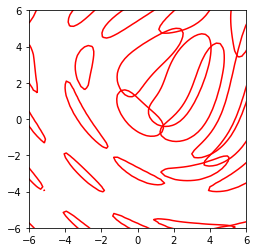

In [37]:
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)

    if D == 2:
        points_grid = np.array([[i,j] for i in np.linspace(-6,6,5) for j in np.linspace(-6,6,5)])

        K_eval = visualize_kernel(kn, np.linspace(-10,10,100), [0.9], colors="red", points = points_grid);
        print K_eval.mean()

        plt.xlim(-plot_size/2,plot_size/2)
        plt.ylim(-plot_size/2,plot_size/2)

In [38]:
scores = np.zeros(niter+1)
sigmas = np.zeros(niter+1)
lams   = np.zeros(niter+1)
lam_alphas  = np.zeros(niter+1)
lam_curves  = np.zeros(niter+1)

fvs = []

In [40]:
t0 = time()

sess = tf.InteractiveSession(config=config)
summary_writer = tf.summary.FileWriter(tb_log_dir, sess.graph)
sess.run(init)

for i in range(niter+1):    

    feed[train_data] = gen_data(ntrain)
    feed[val_data] = gen_data(nvalid)
    feed[points] = feed[train_data]



    if i % (niter/5) == 0 and D == 2:

        fv_val = sess.run(fv, feed_dict={train_data:feed[train_data], 
                                         test_data:eval_points,
                                         points: feed[points]})
        fv_val -= fv_val.mean()
        fv_val = np.exp(fv_val)
        fv_val /= np.sum(fv_val)
        fvs.append(fv_val) 


    train_step.run(feed_dict=feed)
    scores[i], r_norm_val, l_norm_val, curve_val, alpha_val, summ = sess.run([score, r_norm, l_norm, 
                                                                        curve, kn.alpha, merged], 
        feed_dict=feed)

    summary_writer.add_summary(summ, i)

    sigmas[i], lams[i], lam_alphas[i] ,lam_curves[i]  = sess.run([sigma, lam_norm, lam_alpha, lam_curve])

    if i % min(100, niter/5) == 0:
        gv_val = gv.eval(feed)
        print '=================='

        print 'Iteration %5d, score %5.3g (%5.3g), time taken %.2f' % (i, scores[i], -D/4.0, time()-t0)
        if hasattr(p, "grad_multiple"):
            print 'true score', true_score(test_grad_true, gv_val)
        print 'sigma: %.5f' % sigma.eval()
        print 'lam_norm, lam_alpha, lam_curve, lam_weights, %.5g, %.5g, %.5g, %.5g' % (
            lam_norm.eval(), lam_alpha.eval(), lam_curve.eval(), lam_weights.eval())
        print 'alpha: %.5g' % alpha_val.mean()
        print 'rn, ln, c = ', r_norm_val, l_norm_val, curve_val



Iteration     0, score -0.0508 ( -0.5), time taken 11.42
true score 5.54464423005
sigma: 0.97724
lam_norm, lam_alpha, lam_curve, lam_weights, 0.97724, 0.97724, 0.97724, 0.001
alpha: 0.00012693
rn, ln, c =  0.0400148 0.00375574 0.00661921
Iteration   100, score -1.53 ( -0.5), time taken 36.85
true score 3.99751615738
sigma: 0.68101
lam_norm, lam_alpha, lam_curve, lam_weights, 0.057788, 0.057158, 0.046346, 0.001
alpha: 0.0055893
rn, ln, c =  6.70034 1.51164 14.971
Iteration   200, score -2.99 ( -0.5), time taken 59.20
true score 2.41244943402
sigma: 0.51620
lam_norm, lam_alpha, lam_curve, lam_weights, 0.0073314, 0.0057134, 0.0045509, 0.001
alpha: 0.022693
rn, ln, c =  51.6639 18.2223 138.078
Iteration   300, score  -3.1 ( -0.5), time taken 81.44
true score 2.56435595758
sigma: 0.48047
lam_norm, lam_alpha, lam_curve, lam_weights, 0.0022401, 0.0018794, 0.0021132, 0.001
alpha: 0.04705
rn, ln, c =  164.683 94.0627 562.996
Iteration   400, score -2.85 ( -0.5), time taken 103.76
true score 1.6

In [41]:
#np.random.seed(3)
batch_size = 500
rand_train_data = gen_data(batch_size)
rand_test_data = gen_data(batch_size*10)

ge_kn = []
sc =    []
for i in range(rand_test_data.shape[0]/batch_size):
    d = rand_test_data[i*batch_size:(i+1)*batch_size]
    o1, o2 = sess.run([gv, score], feed_dict={train_data: rand_train_data, 
                                              test_data: d, 
                                              points:rand_train_data,
                                              val_data: d})
    ge_kn += [o1]
    sc    += [o2]

ge_kn = np.concatenate(ge_kn,0)
if hasattr(p, "grad_multiple"):
    gt = p.grad_multiple(rand_test_data)
print "cv model score: ", np.mean(sc)
if hasattr(p, "grad_multiple"):
    print "cv true score:  ", true_score(ge_kn, gt)

est = KMCLite(m = 500, sigma = np.exp(0.0024), lmbda = np.exp(-9.1224))

est.fit(rand_train_data)

ge = est.grad(rand_test_data)

sc = []
for i in range(rand_test_data.shape[0]/batch_size):
    d = rand_test_data[i*batch_size:(i+1)*batch_size]
    sc += [est.score(d)]
print "gs model score: ", np.mean(sc)
if hasattr(p, "grad_multiple"):
    print "gs true score:  ", true_score(ge, gt)


cv model score:  -3.31816
cv true score:   1.38927637295
gs model score:  8664.02897451
gs true score:   8660.75080612


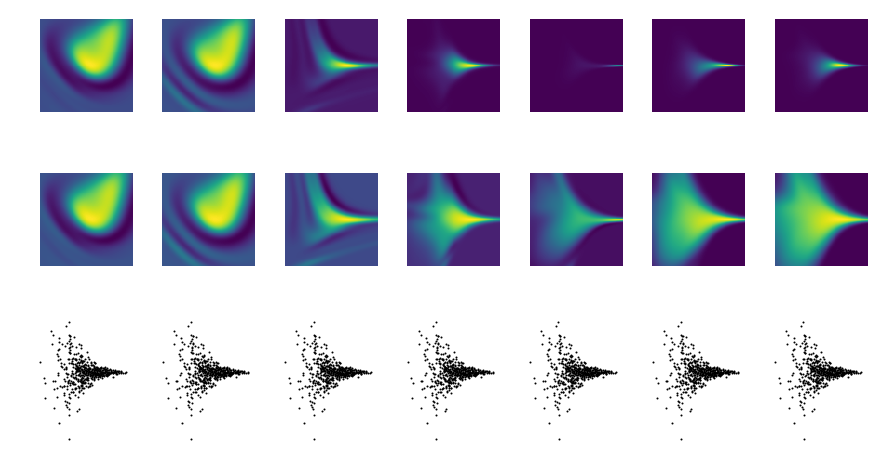

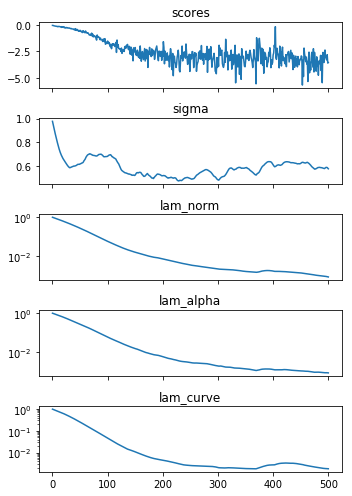

In [42]:
if D == 2:
    nfvs  = len(fvs)
    fig, axes = plt.subplots(3, nfvs,figsize=(15,8), sharex=True, sharey=True)
    rand_data = (ngrid/2)+(rand_train_data*ngrid/plot_size)
    vmin = min(map(np.min, fvs))
    vmax = max(map(np.max, fvs))

    for i in range(len(fvs)):

        iter_number = niter/5*i
        ax = axes[0, i]

        hist = (fvs[i])

        ax.imshow( hist.reshape(ngrid, ngrid).T, origin="lower")
        #ax.set_title("it=%d, sc=%.3f" % (iter_number, scores[iter_number]))
        ax.set_axis_off()

        ax = axes[1, i]
        ax.imshow( np.log(hist).reshape(ngrid, ngrid).T, origin="lower")
        ax.set_axis_off()


        ax = axes[2, i]
        ax.scatter(rand_data[:,0], rand_data[:,1], 1, "k", alpha=1)
        ax.set_axis_off()


    #plt.show()
    #fig.savefig("figs/grid_dist/2d_dist_nt%s_np%d_s%02d.pdf" % (net_type, npoint, seed))
    #fig.savefig("figs/grid_dist/test.pdf") 

fig, axes = plt.subplots(5,1,figsize=(5,7), sharex=True)
ax = axes[0]
ax.plot(scores)
ax.set_title("scores")
ax = axes[1]
ax.plot(sigmas)
ax.set_title("sigma")
ax = axes[2]
ax.plot(lams)
ax.set_title("lam_norm")
ax.set_yscale("log")
ax = axes[3]
ax.plot(lam_alphas)
ax.set_title("lam_alpha")
ax.set_yscale("log")
ax = axes[4]
ax.plot(lam_curves)
ax.set_title("lam_curve")
ax.set_yscale("log")

fig.tight_layout()
#fig.savefig("figs/grid_dist/test_hist.pdf") 

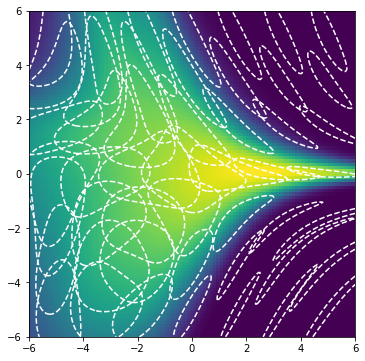

In [43]:
points_grid = np.array([[i,j] for i in np.linspace(-5,5,7) for j in np.linspace(-5,5,7)])

plt.figure(figsize=(6,6))
K = visualize_kernel(kn, np.linspace(-6,6,200), [0.9], points=points_grid, colors="white", linestyles="--")

plt.pcolor(np.linspace(-plot_size/2,plot_size/2,ngrid),np.linspace(-plot_size/2,plot_size/2,ngrid),
           np.log((hist.reshape(ngrid,ngrid))).T)
plt.gca().set_aspect("equal")

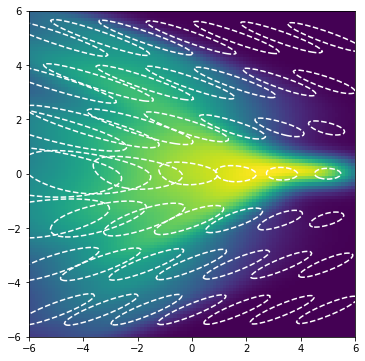

In [262]:
points_grid = np.array([[i,j] for i in np.linspace(-5,5,7) for j in np.linspace(-5,5,7)])

plt.figure(figsize=(6,6))
K = visualize_kernel(kn, np.linspace(-6,6,200), [0.9], points=points_grid, colors="white", linestyles="--")

plt.pcolor(np.linspace(-plot_size/2,plot_size/2,ngrid),np.linspace(-plot_size/2,plot_size/2,ngrid),
           np.log((hist.reshape(ngrid,ngrid))).T)
plt.gca().set_aspect("equal")

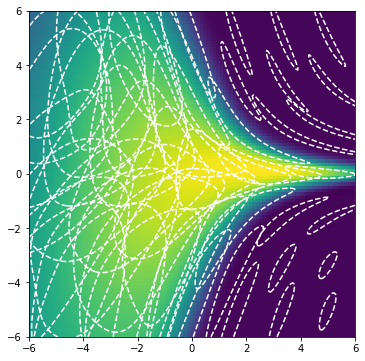

In [252]:
points_grid = np.array([[i,j] for i in np.linspace(-5,5,7) for j in np.linspace(-5,5,7)])

plt.figure(figsize=(6,6))
K = visualize_kernel(kn, np.linspace(-6,6,200), [0.9], points=points_grid, colors="white", linestyles="--")

plt.pcolor(np.linspace(-plot_size/2,plot_size/2,ngrid),np.linspace(-plot_size/2,plot_size/2,ngrid),
           np.log((hist.reshape(ngrid,ngrid))).T)
plt.gca().set_aspect("equal")

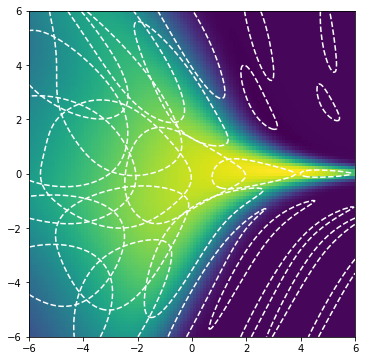

In [282]:
points_grid = np.array([[i,j] for i in np.linspace(-5,5,5) for j in np.linspace(-5,5,5)])

plt.figure(figsize=(6,6))
K = visualize_kernel(kn, np.linspace(-6,6,200), [0.9], points=points_grid, colors="white", linestyles="--")

plt.pcolor(np.linspace(-plot_size/2,plot_size/2,ngrid),np.linspace(-plot_size/2,plot_size/2,ngrid),
           np.log((hist.reshape(ngrid,ngrid))).T)
plt.gca().set_aspect("equal")

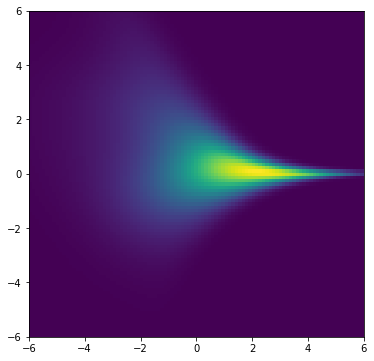

In [18]:
plt.figure(figsize=(6,6))
plt.pcolor(np.linspace(-plot_size/2,plot_size/2,ngrid),np.linspace(-plot_size/2,plot_size/2,ngrid),
           ((hist.reshape(ngrid,ngrid))).T)

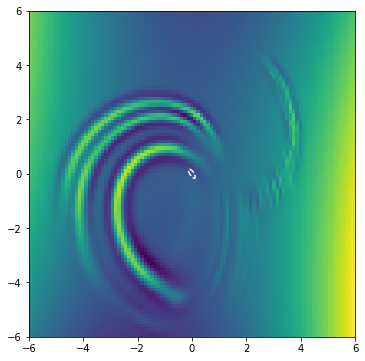

In [18]:
points_grid = np.array([[i,j] for i in np.linspace(-5,5,5) for j in np.linspace(-5,5,5)])

plt.figure(figsize=(6,6))
K = visualize_kernel(kn, np.linspace(-6,6,200), [0.9], points=points_grid, colors="white", linestyles="--")

plt.pcolor(np.linspace(-plot_size/2,plot_size/2,ngrid),np.linspace(-plot_size/2,plot_size/2,ngrid),
           np.log((hist.reshape(ngrid,ngrid))).T)
plt.gca().set_aspect("equal")

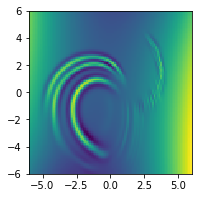

In [26]:
points_grid = np.array([[i,j] for i in np.linspace(-5,5,9) for j in np.linspace(-5,5,9)])

plt.figure(figsize=(3,3))
#K = visualize_kernel(kn, np.linspace(-6,6,200), [0.1], points=points_grid, colors="white", linestyles="--")

plt.pcolor(np.linspace(-plot_size/2,plot_size/2,ngrid),np.linspace(-plot_size/2,plot_size/2,ngrid),
           np.log((hist.reshape(ngrid,ngrid))).T)
plt.gca().set_aspect("equal")

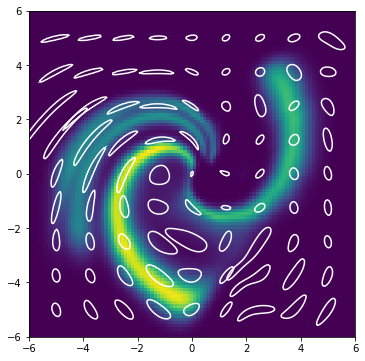

In [59]:
points_grid = np.array([[i,j] for i in np.linspace(-5,5,9) for j in np.linspace(-5,5,9)])

plt.figure(figsize=(6,6))
K = visualize_kernel(kn, np.linspace(-6,6,200), [0.9], points=points_grid, colors="white")

plt.pcolor(np.linspace(-plot_size/2,plot_size/2,ngrid),np.linspace(-plot_size/2,plot_size/2,ngrid),
           np.log((hist.reshape(ngrid,ngrid))).T)
plt.gca().set_aspect("equal")